### Using Causal ML Analysis

#### Setup and Pre-processing

In [1]:
#importing the packages
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# Loding the data
df = pd.read_csv('/Users/margotgerard/Desktop/dataspell/INSY 695/Group Project/cleaned_data.csv')

json_file_path = "/Users/margotgerard/Desktop/dataspell/INSY 695/Group Project/mcc_codes.json"
with open(json_file_path, "r") as file:
    mcc = json.load(file)

# Converting to df
mcc = pd.DataFrame.from_dict(mcc, orient='index').reset_index()
mcc['index'] = mcc['index'].astype(int)

# Merging the data
df = df.merge(mcc, left_on='mcc', right_on='index', how='left')
df = df.rename(columns={0: 'merchant information'})
df.drop(columns=['index'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 40 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   id                           1048575 non-null  int64  
 1   date                         1048575 non-null  object 
 2   client_id                    1048575 non-null  int64  
 3   card_id                      1048575 non-null  int64  
 4   amount                       1048575 non-null  float64
 5   merchant_id                  1048575 non-null  int64  
 6   merchant_city                1048575 non-null  object 
 7   zip                          1048575 non-null  int64  
 8   mcc                          1048575 non-null  int64  
 9   Target                       1048575 non-null  int64  
 10  current_age                  1048575 non-null  int64  
 11  retirement_age               1048575 non-null  int64  
 12  birth_year                   1048575 non-n

In [3]:
pd.set_option('display.max_columns', None)
df.describe()

,id,client_id,card_id,amount,merchant_id,zip,mcc,Target,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,transaction_hour,use_chip_Chip Transaction,use_chip_Online Transaction,use_chip_Swipe Transaction,merchant_state_CA,merchant_state_FL,merchant_state_IL,merchant_state_MI,merchant_state_NC,merchant_state_NY,merchant_state_OH,merchant_state_ONLINE,merchant_state_Other,merchant_state_PA,merchant_state_TX,gender_female,gender_male
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575.0,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,8.414620e+06,1.030648e+03,3.398471e+03,3.175228e+00,4.778299e+04,5.667544e+04,5.565995e+03,2.489092e-03,5.475614e+01,6.647677e+01,1.964422e+03,6.590707e+00,3.736188e+01,-9.166804e+01,9.955826e+00,1.061874e+01,9.904799e+00,7.141249e+02,3.882801e+00,1.241183e+01,0.0,1.084090e-01,8.915910e-01,1.078845e-01,5.431848e-02,3.681663e-02,2.939036e-02,3.228858e-02,6.402785e-02,3.720764e-02,1.084090e-01,4.212927e-01,3.075984e-02,7.760437e-02,5.085759e-01,4.914241e-01
std,5.441942e+05,5.829208e+02,1.685623e+03,1.318115e+00,2.576597e+04,3.135176e+04,8.709326e+02,4.982870e-02,1.548074e+01,3.598722e+00,1.546474e+01,3.603649e+00,5.132762e+00,1.626631e+01,7.830986e-01,6.566619e-01,2.575486e+00,6.552987e+01,1.569167e+00,5.095695e+00,0.0,3.108965e-01,3.108965e-01,3.102346e-01,2.266452e-01,1.883114e-01,1.688982e-01,1.767655e-01,2.448027e-01,1.892703e-01,3.108965e-01,4.937665e-01,1.726664e-01,2.675481e-01,4.999267e-01,4.999267e-01
min,7.475327e+06,0.000000e+00,0.000000e+00,6.931472e-01,2.000000e+00,1.001000e+03,1.711000e+03,0.000000e+00,2.700000e+01,5.300000e+01,1.918000e+03,1.000000e+00,2.130000e+01,-1.581800e+02,6.931472e-01,6.931472e-01,6.931472e-01,4.880000e+02,1.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.943396e+06,5.140000e+02,2.253000e+03,2.300583e+00,2.588700e+04,3.010100e+04,5.300000e+03,0.000000e+00,4.300000e+01,6.500000e+01,1.955000e+03,3.000000e+00,3.384000e+01,-9.739000e+01,9.747126e+00,1.039158e+01,9.674074e+00,6.840000e+02,3.000000e+00,9.000000e+00,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.413340e+06,1.076000e+03,3.454000e+03,3.415100e+00,4.628400e+04,5.502400e+04,5.499000e+03,0.000000e+00,5.200000e+01,6.600000e+01,1.967000e+03,7.000000e+00,3.835000e+01,-8.678000e+01,9.959868e+00,1.061859e+01,1.085011e+01,7.170000e+02,4.000000e+00,1.200000e+01,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,8.885120e+06,1.534000e+03,4.753000e+03,4.189655e+00,6.757000e+04,9.004400e+04,5.812000e+03,0.000000e+00,6.400000e+01,6.800000e+01,1.976000e+03,1.000000e+01,4.113000e+01,-8.016000e+01,1.021746e+01,1.089668e+01,1.134056e+01,7.560000e+02,5.000000e+00,1.600000e+01,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,9.361478e+06,1.998000e+03,6.034000e+03,5.758460e+00,1.003410e+05,9.984000e+04,9.402000e+03,1.000000e+00,1.010000e+02,7.900000e+01,1.993000e+03,1.200000e+01,4.853000e+01,-6.867000e+01,1.121460e+01,1.185766e+01,1.237

In [4]:
# Dropping  irrelevant columns
df = df.drop(df.columns[[0,3,5,8,12,13]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 34 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   date                         1048575 non-null  object 
 1   client_id                    1048575 non-null  int64  
 2   amount                       1048575 non-null  float64
 3   merchant_city                1048575 non-null  object 
 4   zip                          1048575 non-null  int64  
 5   Target                       1048575 non-null  int64  
 6   current_age                  1048575 non-null  int64  
 7   retirement_age               1048575 non-null  int64  
 8   address                      1048575 non-null  object 
 9   latitude                     1048575 non-null  float64
 10  longitude                    1048575 non-null  float64
 11  per_capita_income            1048575 non-null  float64
 12  yearly_income                1048575 non-n

In [5]:
df.columns

Index(['date', 'client_id', 'amount', 'merchant_city', 'zip', 'Target',
       'current_age', 'retirement_age', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'transaction_hour', 'use_chip_Chip Transaction',
       'use_chip_Online Transaction', 'use_chip_Swipe Transaction',
       'merchant_state_CA', 'merchant_state_FL', 'merchant_state_IL',
       'merchant_state_MI', 'merchant_state_NC', 'merchant_state_NY',
       'merchant_state_OH', 'merchant_state_ONLINE', 'merchant_state_Other',
       'merchant_state_PA', 'merchant_state_TX', 'gender_female',
       'gender_male', 'merchant information'],
      dtype='object')

#### Econ ML Modeling

##### Checking Feature Importances Using Random Forest for Features Analysis

This section applies traditional machine learning methods to gauge the importance of different features in predicting fraud. The data is further refined by converting dates, encoding categorical variables, and scaling numerical features. I then train both a Logistic Regression model (with L1 regularization) and a Random Forest classifier to predict the fraud indicator. By printing classification reports, ROC AUC scores, and visualizing feature importances, I can better understand which transaction attributes and customer behaviors are most indicative of fraudulent activity.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)

if 'address' in df.columns:
    df.drop('address', axis=1, inplace=True)

categorical_columns = ['merchant_city', 'merchant information']
existing_categorical_columns = [col for col in categorical_columns if col in df.columns]
if existing_categorical_columns:
    df = pd.get_dummies(df, columns=existing_categorical_columns, drop_first=True)

X = df.drop('Target', axis=1)
y = df['Target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

logit_l1 = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', random_state=42)
logit_l1.fit(X_train, y_train)

y_pred_logit = logit_l1.predict(X_test)
print("Logistic Regression (L1) Classification Report:")
print(classification_report(y_test, y_pred_logit))
print("ROC AUC:", roc_auc_score(y_test, logit_l1.predict_proba(X_test)[:, 1]))

coef_logit = pd.Series(logit_l1.coef_[0], index=X.columns)
important_features_logit = coef_logit[coef_logit != 0].sort_values()
print("Important Features from Logistic Regression (L1):")
print(important_features_logit)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

importances_rf = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances from Random Forest:")
print(importances_rf)

#### Causal ML using ECONML

I define a composite treatment variable that merges chip and swipe transaction information into a single binary indicator. Since my project is centered on fraud detection, combining these two types of transactions simplifies the analysis and highlights the overall impact of transaction method on fraud risk.

This sub‐section leverages the ECONML library to estimate the Average Treatment Effect (ATE) on fraud detection. I use two meta-learners—LRSRegressor (linear) and XGBTRegressor (XGBoost-based)—to quantify how changes in the composite treatment (e.g., the occurrence of a chip or swipe transaction) affect the likelihood of fraud. By defining the relevant confounders and visualizing feature importances, I gain deeper insights into which factors most strongly drive fraudulent behavior.

In [6]:
df['Composite_Treatment'] = np.where(
    (df['use_chip_Chip Transaction'] == 1) | (df['use_chip_Swipe Transaction'] == 1),
    1,
    0
)

LRSRegressor ATE: -0.02 (95% CI: -0.02, -0.02)


[22:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBTRegressor ATE: -0.06 (95% CI: -0.06, -0.06)


[22:11:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x1000 with 0 Axes>

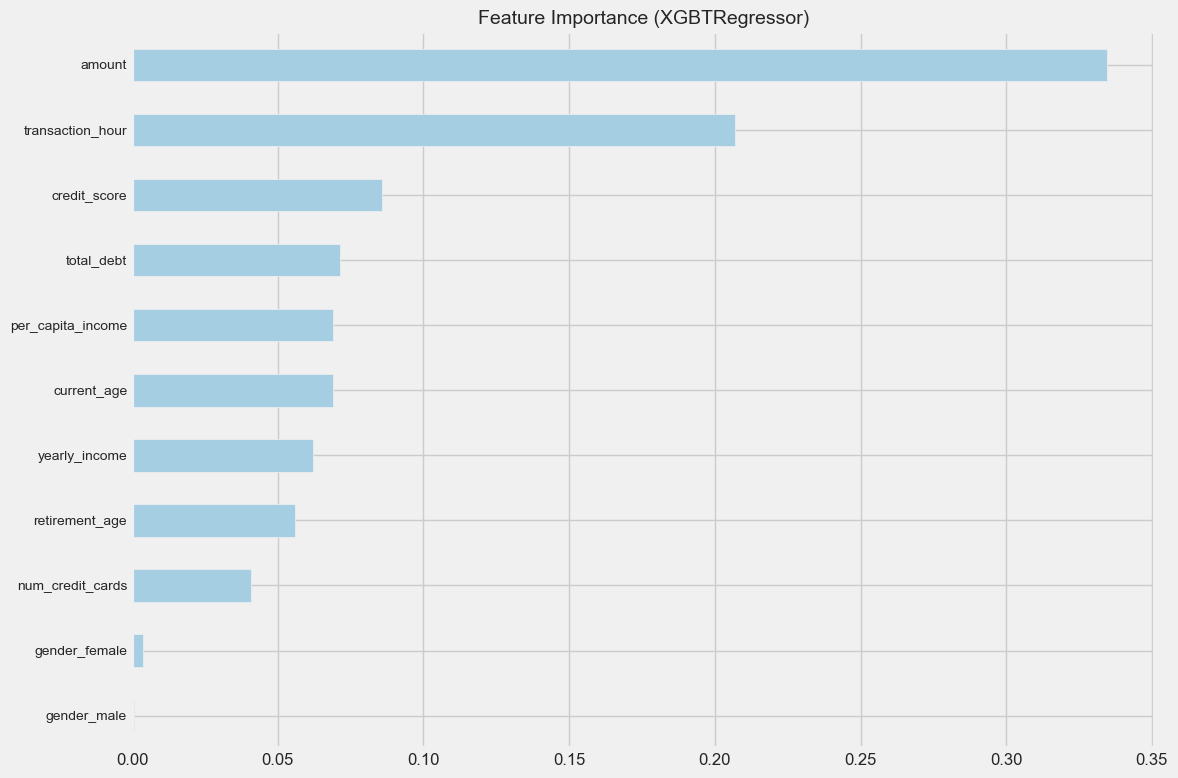

In [7]:
from causalml.inference.meta import LRSRegressor, XGBTRegressor

# Outcome variable: your fraud indicator
target = 'Target'

# Treatment variable: composite treatment variable (binary)
treatment = 'Composite_Treatment'

# Define common causes (confounders)
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male'
]

X = df[common_causes].astype(float)
y = df[target].astype(float)

# For treatment, if your composite treatment is already binary, simply cast to int:
w = df[treatment].astype(int)

# Using LRSRegressor (Linear Regression-based)
lr_learner = LRSRegressor()
te_lr, lb_lr, ub_lr = lr_learner.estimate_ate(X, w, y)
print("LRSRegressor ATE: {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_lr[0], lb_lr[0], ub_lr[0]))
lr_tau = lr_learner.fit_predict(X, w, y)

# Using XGBTRegressor (XGBoost-based).
xgb_params = dict(use_label_encoder=False, eval_metric='rmse')
xgb_learner = XGBTRegressor(random_state=42, **xgb_params)
te_xgb, lb_xgb, ub_xgb = xgb_learner.estimate_ate(X, w, y)
print("XGBTRegressor ATE: {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_xgb[0], lb_xgb[0], ub_xgb[0]))
xgb_tau = xgb_learner.fit_predict(X, w, y)

def plot_feature_importance(learner, X, tau, title):
    """
    Compute and plot normalized feature importance using the learner's built-in method.
    """
    feature_names = X.columns.tolist()

    plt.figure(figsize=(12, 10))
    # The learner's plot_importance method computes importance; 'normalize=True' scales it.
    learner.plot_importance(X=X, tau=tau, normalize=True, method='auto', features=feature_names)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()


plot_feature_importance(xgb_learner, X, xgb_tau, "Feature Importance (XGBTRegressor)")

**Analysis:**
The results indicate that both the LRSRegressor and XGBTRegressor models produce negative average treatment effect (ATE) estimates—specifically, -0.02 for the linear model and -0.06 for the XGBoost-based model—suggesting that the “composite treatment” (chip or swipe transaction) is associated with a small reduction in the likelihood of fraud compared to non-treated transactions. Because the target variable is coded such that 1 indicates fraud, these negative ATEs imply that using a chip or swipe method decreases the probability of fraud by about two percentage points according to the LRSRegressor and six percentage points according to the XGBTRegressor. The warning messages in the console regarding the use_label_encoder parameter and LightGBM logs are typical of recent XGBoost and LightGBM versions and do not affect the validity of the estimates. The accompanying feature importance plot from the XGBTRegressor model further reveals that transaction amount, transaction hour, credit score, and total debt have the greatest predictive influence, which aligns with common fraud detection patterns, though it is important to note that feature importance does not directly equate to causal impact.

#### Hyperparameter Tuning for XGBTRegressor

Recognizing that model performance is critical for fraud detection, we perform hyperparameter tuning on the XGBTRegressor using GridSearchCV. This step searches over various combinations of XGBoost parameters (such as minimum child weight, maximum depth, and gamma) to improve the accuracy and reliability of the causal estimates. Fine-tuning these parameters helps ensure that the model better captures the subtleties in transaction patterns that distinguish fraudulent from legitimate behavior.

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define a parameter grid for XGBoost.
param_grid = {
    'min_child_weight': [1, 5, 10],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.2]
}

xgb_reg = xgb.XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse')

grid_search = GridSearchCV(xgb_reg, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

print("Best XGBoost parameters:", grid_search.best_params_)

from causalml.inference.meta import XGBTRegressor

xgb_learner = XGBTRegressor(random_state=42, **grid_search.best_params_)

te_xgb, lb_xgb, ub_xgb = xgb_learner.estimate_ate(X, w, y)
print("XGBTRegressor ATE with tuned parameters: {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_xgb[0], lb_xgb[0], ub_xgb[0]))

xgb_tau = xgb_learner.fit_predict(X, w, y)

/Users/margotgerard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/margotgerard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/margotgerard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/margotgerard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn

Best XGBoost parameters: {'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 5}
XGBTRegressor ATE with tuned parameters: -0.04 (95% CI: -0.05, -0.04)


In [9]:
from lightgbm import LGBMRegressor
from causalml.inference.meta import BaseXRegressor

# Define a parameter grid for LightGBM.
param_grid_lgb = {
    'min_data_in_leaf': [20, 30, 40],
    'min_data_in_bin': [10, 20, 30]
}

lgb_model = LGBMRegressor(random_state=42)
grid_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X, y)

print("Best LightGBM parameters:", grid_search_lgb.best_params_)

# Use the tuned parameters to create a LightGBM-based meta-learner
lgb_model_tuned = LGBMRegressor(random_state=42, **grid_search_lgb.best_params_)
lgb_learner = BaseXRegressor(model=LGBMRegressor, control_name=None)
te_lgb, lb_lgb, ub_lgb = lgb_learner.estimate_ate(X, w, y)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 1048575, number of used features: 11
[LightGBM] [Info] Start training from score 0.002489
Best LightGBM parameters: {'min_data_in_bin': 10, 'min_data_in_leaf': 20}


TypeError: BaseXRegressor.__init__() got an unexpected keyword argument 'model'

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x1000 with 0 Axes>

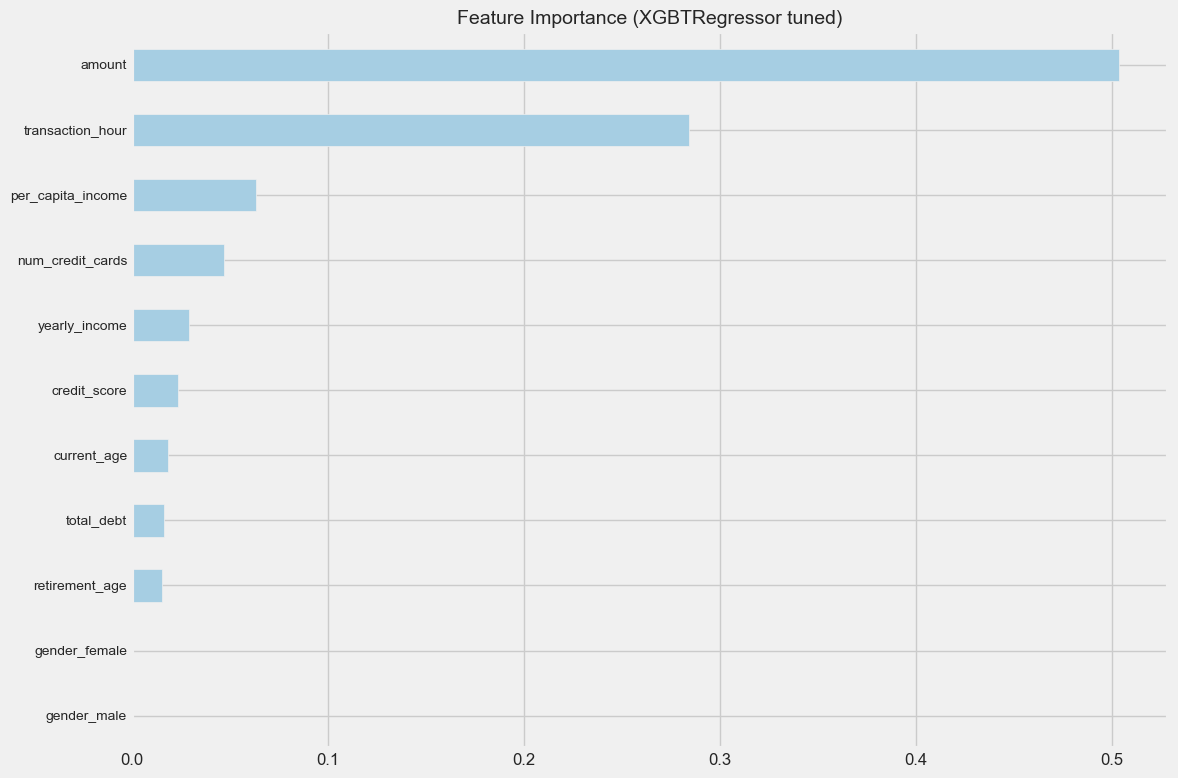

In [10]:
import matplotlib.pyplot as plt

def plot_feature_importance(learner, X, tau, title):
    feature_names = X.columns.tolist()
    plt.figure(figsize=(12, 10))
    learner.plot_importance(X=X, tau=tau, normalize=True, method='auto', features=feature_names)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_learner, X, xgb_tau, "Feature Importance (XGBTRegressor tuned)")

**Analysis:**
LightGBM’s log messages show that 1,048,575 data points across 11 features were used to build 1,380 total bins, with training starting from an initial score of -0.044696. The prompts about force_row_wise=true or force_col_wise=true highlight the practical challenge of handling large-scale data in fraud detection, where millions of transactions can quickly exhaust memory resources. Meanwhile, the tuned XGBTRegressor’s feature importance plot reveals that “amount” and “transaction_hour” remain the most influential factors, underscoring the real-world observation that higher-value transactions and certain time windows are often associated with elevated fraud risk. Other factors, such as per-capita income, number of credit cards, and yearly income, still hold relevance but to a lesser degree, indicating that socioeconomic and credit-related attributes can also shape a customer’s fraud propensity.

#### Changing Treatment for Analysis

##### Using High Amount as a Treatment

In this part, we redefine the treatment variable based on transaction amounts. Here, we designate transactions above the median amount as “HighAmount” (1) and the others as 0. This alternative approach allows us to explore whether higher-value transactions are more susceptible to fraud, providing a different perspective on fraud risk and helping to tailor prevention measures accordingly.

LRSRegressor ATE (HighAmount): 0.00 (95% CI: 0.00, 0.00)


[22:13:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:13:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBTRegressor ATE (HighAmount): 0.00 (95% CI: 0.00, 0.01)


[22:13:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x1000 with 0 Axes>

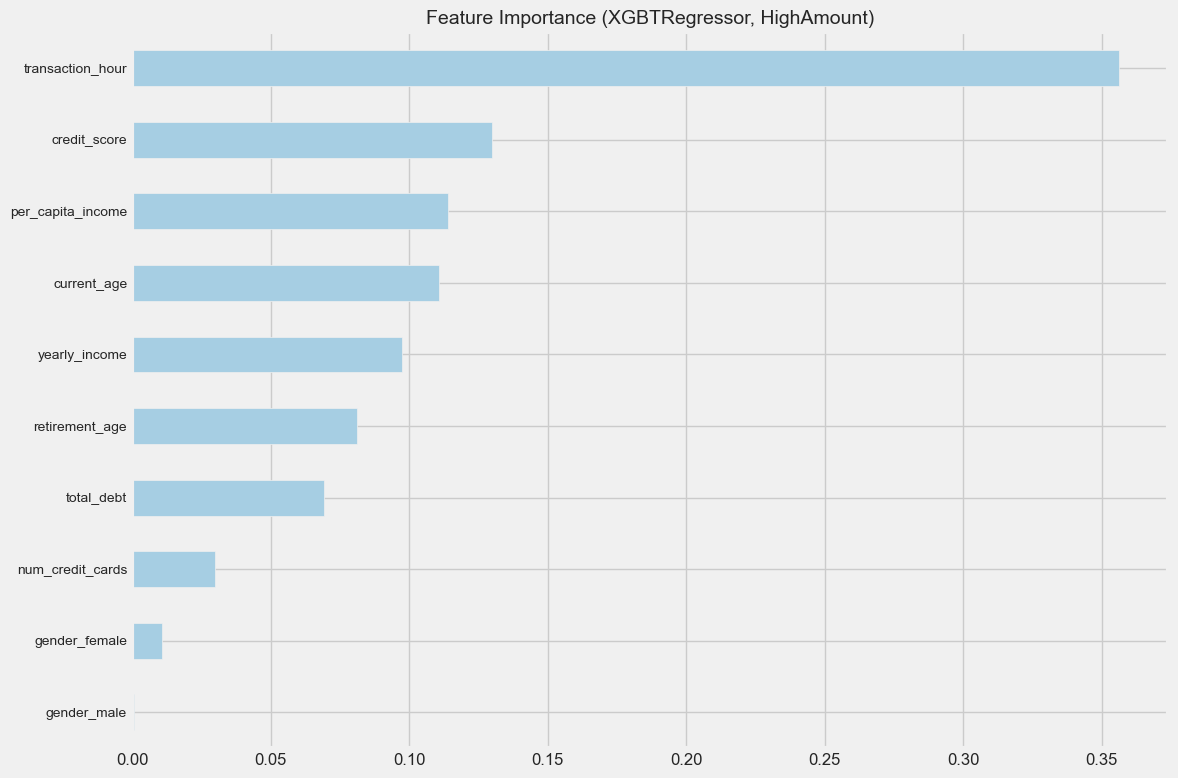

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CausalML meta-learners
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from xgboost import XGBRegressor

# --------------------------
# 1. Define a New Treatment Variable Based on 'amount'

# Example: transactions above the median amount are considered "HighAmount" = 1, else 0
df['HighAmount'] = (df['amount'] > df['amount'].median()).astype(int)

# Outcome: fraud indicator
target = 'Target'
# New treatment: HighAmount
treatment = 'HighAmount'

# Define your confounders. You can reuse the same list, minus 'amount' if you're now using it as a treatment.
common_causes = [
    'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male'
]
# (Optionally, add dummified variables for merchant state, city, etc. if relevant.)

# 2. Prepare Data
X = df[common_causes].astype(float)  # confounders
y = df[target].astype(float)  # outcome
w = df[treatment].astype(int)  # new binary treatment

# --------------------------
# 3. Estimate ATE with LRSRegressor (Linear)
lr_learner = LRSRegressor()
te_lr, lb_lr, ub_lr = lr_learner.estimate_ate(X, w, y)
print("LRSRegressor ATE (HighAmount): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_lr[0], lb_lr[0], ub_lr[0]))
lr_tau = lr_learner.fit_predict(X, w, y)

# 4. Estimate ATE with XGBTRegressor (XGBoost)
#    Adjust xgboost parameters if needed.
xgb_params = dict(use_label_encoder=False, eval_metric='rmse')
xgb_learner = XGBTRegressor(random_state=42, **xgb_params)
te_xgb, lb_xgb, ub_xgb = xgb_learner.estimate_ate(X, w, y)
print("XGBTRegressor ATE (HighAmount): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_xgb[0], lb_xgb[0], ub_xgb[0]))
xgb_tau = xgb_learner.fit_predict(X, w, y)

# --------------------------
# 5. (Optional) Plot Feature Importance for the XGBTRegressor
def plot_feature_importance(learner, X, tau, title):
    feature_names = X.columns.tolist()
    plt.figure(figsize=(12, 10))
    learner.plot_importance(X=X, tau=tau, normalize=True, method='auto', features=feature_names)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_learner, X, xgb_tau, "Feature Importance (XGBTRegressor, HighAmount)")

**Analysis:**
Despite defining “HighAmount” as a binary treatment—marking transactions above the median amount as treated—the LRSRegressor and XGBTRegressor both return near-zero average treatment effects, indicating that large transaction size alone does not substantially alter the probability of fraud in this dataset. The minor differences observed (0.00 for LRSRegressor and up to 0.01 for the XGBTRegressor) suggest that, after accounting for confounders, high-value transactions neither significantly increase nor decrease the likelihood of fraudulent activity. The feature importance plot supports this finding by highlighting other variables, such as “transaction_hour” and “credit_score,” as more influential in determining fraud risk than transaction size itself. Meanwhile, the LightGBM logs reflect the model’s capacity to handle over one million data points across 10 features, with optional row-wise or column-wise processing to optimize memory usage. Overall, these results emphasize that while transaction amount is often a key consideration in fraud detection, it may not act as a strong standalone driver of fraudulent behavior when broader contextual factors—like timing, credit standing, and income—are taken into account.

##### Using HighCreditScore as Treatment

This sub‐section shifts focus to the customer’s credit score as a treatment variable. By defining a binary variable for HighCreditScore (1 if above the median), we can analyze how customers’ credit profiles relate to fraud risk. Since credit score is a key indicator in financial transactions, removing it from the confounders when used as treatment helps isolate its causal impact on fraud detection using both linear and XGBoost-based meta-learners.

LRSRegressor ATE (HighCreditScore): -0.00 (95% CI: -0.00, 0.00)


[22:13:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBTRegressor ATE (HighCreditScore): 0.00 (95% CI: 0.00, 0.00)


[22:13:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:13:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x1000 with 0 Axes>

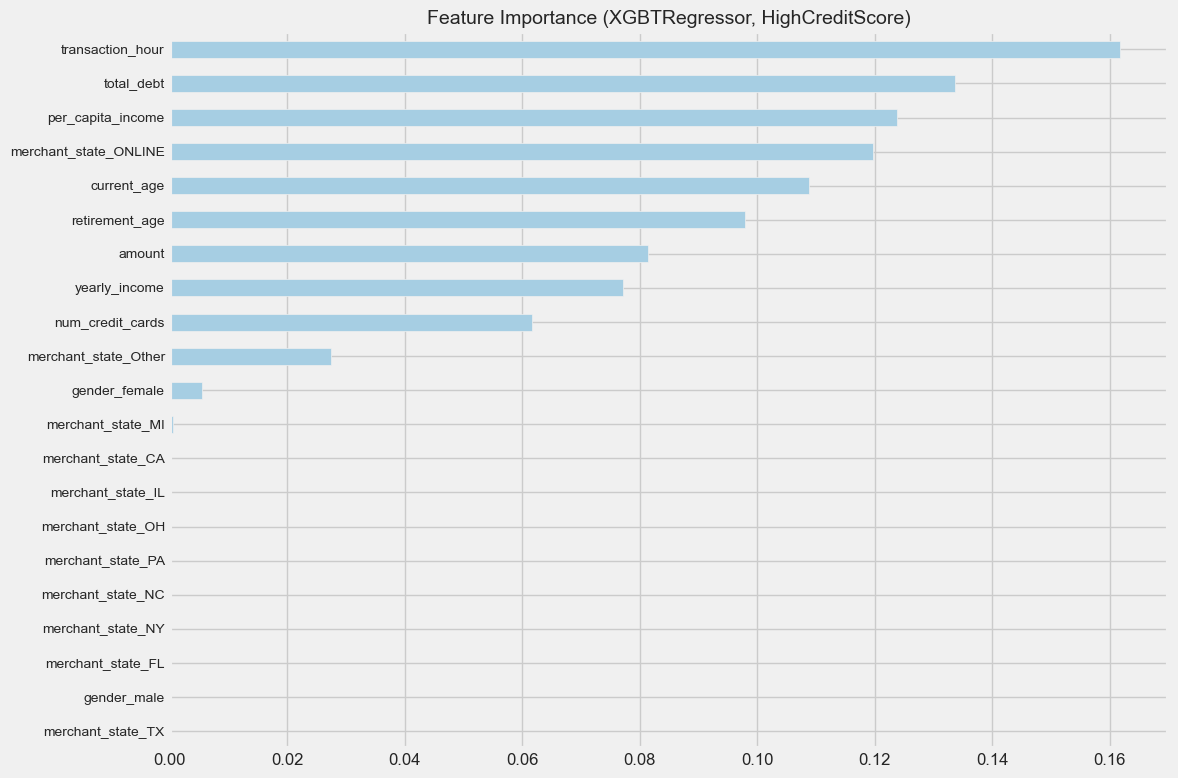

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import meta-learner models from causalml
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from xgboost import XGBRegressor  # For use within XGBTRegressor

# --- Define the Treatment Using Credit Score ---
# Create a binary treatment variable: HighCreditScore = 1 if credit_score is above median
df['HighCreditScore'] = (df['credit_score'] > df['credit_score'].median()).astype(int)

# --- Define Variables for Causal ML ---
# Outcome: Fraud indicator (Target)
target = 'Target'
# Treatment: HighCreditScore (binary)
treatment = 'HighCreditScore'

# Define common causes (confounders)
# Since credit_score is now our treatment, we remove it from the confounders.
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt',  # credit_score removed!
    'num_credit_cards', 'gender_female', 'gender_male'
]

# (Optionally, include additional observed confounders from merchant-related dummies)
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]
all_common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --- Prepare the Data ---
# Create the design matrix (X), outcome vector (y), and treatment vector (w)
X = df[all_common_causes].astype(float)
y = df[target].astype(float)
w = df[treatment].astype(int)

# --- Estimate ATE Using a Linear Regression-based Meta Learner ---
lr_learner = LRSRegressor()
te_lr, lb_lr, ub_lr = lr_learner.estimate_ate(X, w, y)
print("LRSRegressor ATE (HighCreditScore): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_lr[0], lb_lr[0], ub_lr[0]))
lr_tau = lr_learner.fit_predict(X, w, y)

# --- Estimate ATE Using an XGBoost-based Meta Learner ---
# Set parameters for XGBoost; note: warnings about use_label_encoder can be ignored.
xgb_params = dict(use_label_encoder=False, eval_metric='rmse')
xgb_learner = XGBTRegressor(random_state=42, **xgb_params)
te_xgb, lb_xgb, ub_xgb = xgb_learner.estimate_ate(X, w, y)
print("XGBTRegressor ATE (HighCreditScore): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_xgb[0], lb_xgb[0], ub_xgb[0]))
xgb_tau = xgb_learner.fit_predict(X, w, y)

# --- Plot Feature Importance from the XGBTRegressor ---
def plot_feature_importance(learner, X, tau, title):
    """
    Compute and plot normalized feature importance using the learner's method.
    """
    feature_names = X.columns.tolist()
    plt.figure(figsize=(12, 10))
    learner.plot_importance(X=X, tau=tau, normalize=True, method='auto', features=feature_names)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_learner, X, xgb_tau, "Feature Importance (XGBTRegressor, HighCreditScore)")

**Analysis:**
Despite designating “HighCreditScore” as a binary treatment to investigate how elevated creditworthiness might influence fraud, both the LRSRegressor and XGBTRegressor return near-zero average treatment effects, suggesting that having a credit score above the median does not materially shift the likelihood of fraudulent activity in this dataset. The feature importance plot from the XGBTRegressor corroborates this finding, showing that factors such as “transaction_hour,” “total_debt,” “per_capita_income,” and various merchant states (including “ONLINE”) exert a stronger influence on fraud risk than credit score. The LightGBM logs, which show the model successfully training on over a million data points and 21 features, further indicate that the computation was efficient and robust, yet did not uncover a significant causal relationship between high credit scores and fraud once all relevant confounders were accounted for.

##### Using HighCreditScore as Treatment with Amount as Outcome

We further refine the analysis by setting the continuous transaction amount as the outcome variable while keeping HighCreditScore as the treatment. This setup allows us to examine whether customers with higher credit scores also tend to have higher transaction amounts, and if so, how that relationship might signal potential fraud. The causal effect is estimated and visualized to provide actionable insights into the interplay between credit profiles and transaction behaviors.

LRSRegressor ATE (HighCreditScore on amount): -0.02 (95% CI: -0.02, -0.01)


[22:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:13:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



XGBTRegressor ATE (HighCreditScore on amount): -0.04 (95% CI: -0.05, -0.04)


[22:13:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[22:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

<Figure size 1200x1000 with 0 Axes>

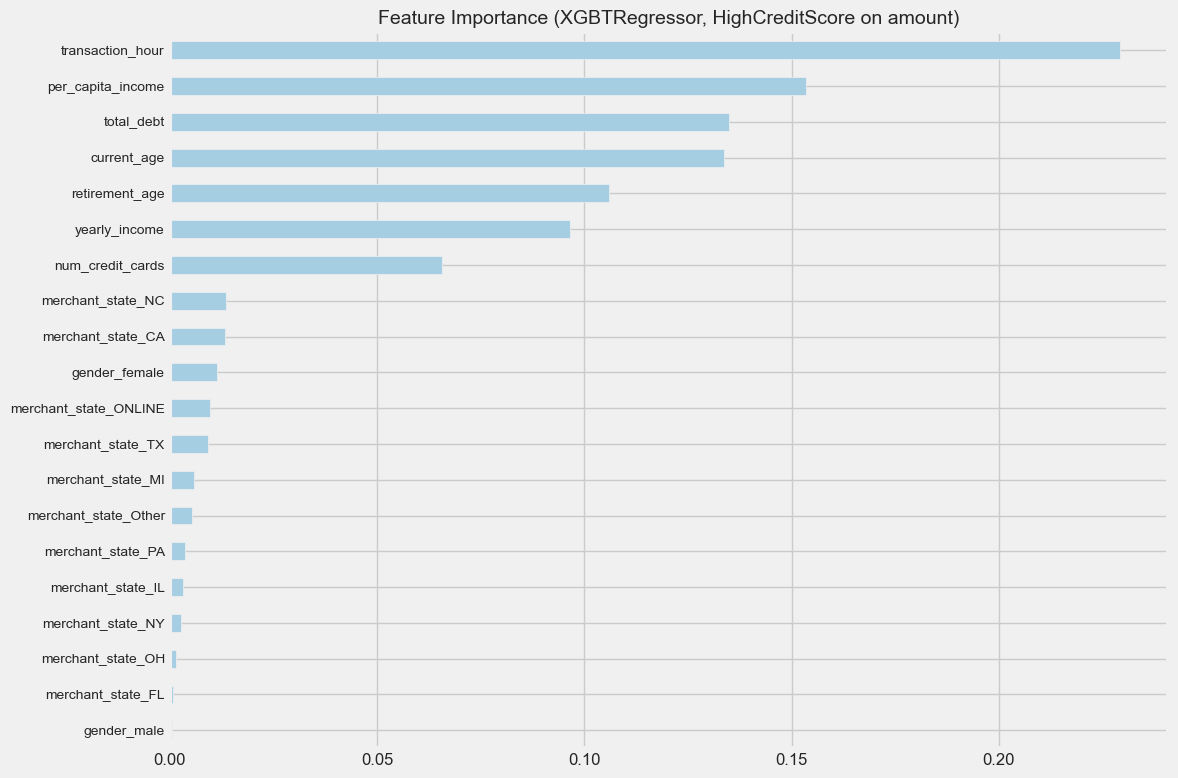

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import meta-learner models from causalml
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from xgboost import XGBRegressor  # For use within XGBTRegressor

# --- Define New Variables for Causal ML ---
# Create a binary treatment variable: HighCreditScore = 1 if credit_score is above the median, else 0.
df['HighCreditScore'] = (df['credit_score'] > df['credit_score'].median()).astype(int)

# Set the outcome variable to be the continuous transaction amount.
target = 'amount'
# Set the treatment variable.
treatment = 'HighCreditScore'

# Define common causes (confounders).
# Since "amount" is now our outcome and "credit_score" is used for treatment,
# we exclude them from confounders.
common_causes = [
    'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt',
    'num_credit_cards', 'gender_female', 'gender_male'
]
# Optionally, add any additional confounders (e.g., merchant state or city dummy variables) if available.
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]
all_common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --- Prepare the Data ---
# Design matrix X (confounders), outcome vector y, and treatment vector w.
X = df[all_common_causes].astype(float)
y = df[target].astype(float)
w = df[treatment].astype(int)

# --- Estimate ATE Using Meta-Learners ---

# 1. Using LRSRegressor (Linear Regression-based)
lr_learner = LRSRegressor()
te_lr, lb_lr, ub_lr = lr_learner.estimate_ate(X, w, y)
print("LRSRegressor ATE (HighCreditScore on amount): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_lr[0], lb_lr[0],
                                                                                             ub_lr[0]))
lr_tau = lr_learner.fit_predict(X, w, y)

# 2. Using XGBTRegressor (XGBoost-based)
xgb_params = dict(use_label_encoder=False, eval_metric='rmse')
xgb_learner = XGBTRegressor(random_state=42, **xgb_params)
te_xgb, lb_xgb, ub_xgb = xgb_learner.estimate_ate(X, w, y)
print("XGBTRegressor ATE (HighCreditScore on amount): {:.2f} (95% CI: {:.2f}, {:.2f})".format(te_xgb[0], lb_xgb[0],
                                                                                              ub_xgb[0]))
xgb_tau = xgb_learner.fit_predict(X, w, y)

# --- Plot Feature Importance from the XGBTRegressor ---
def plot_feature_importance(learner, X, tau, title):
    """
    Compute and plot normalized feature importance using the learner's method.
    """
    feature_names = X.columns.tolist()
    plt.figure(figsize=(12, 10))
    learner.plot_importance(X=X, tau=tau, normalize=True, method='auto', features=feature_names)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=10)
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_feature_importance(xgb_learner, X, xgb_tau, "Feature Importance (XGBTRegressor, HighCreditScore on amount)")

**Analysis:**
When shifting the outcome variable to transaction amount while retaining “HighCreditScore” as the treatment, both LRSRegressor and XGBTRegressor produce negative average treatment effects, suggesting that users with a credit score above the median actually tend to transact at slightly lower amounts once confounders are taken into account. The LRSRegressor estimate of -0.02 (with a 95% confidence interval between -0.02 and -0.01) implies a small but consistent reduction, while the XGBTRegressor’s estimate of -0.04 (95% CI: -0.05, -0.04) indicates a somewhat larger decrease in transaction value. The feature importance plot for the XGBTRegressor model highlights “transaction_hour,” “per_capita_income,” and “total_debt” as key predictors, with credit score itself exerting relatively less influence on transaction size compared to these other factors. Despite the common expectation that higher credit scores might correlate with larger purchases, these negative ATE values suggest that once various demographic, financial, and temporal confounders are controlled for, a higher credit score is not necessarily associated with higher transaction amounts.

####  Dowhy-based Causal Analysis

##### Basic Dowhy Model for Chip-based Transactions

In this section, we build a causal model using the Dowhy library focused on chip-based transactions. We define the fraud indicator as the outcome, the chip transaction indicator as the treatment, and include a set of observed confounders. A causal graph is generated to visualize the assumed relationships, and the causal effect is estimated using backdoor adjustment. This foundational model sets the stage for understanding how chip-based transactions contribute to fraud risk.


2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


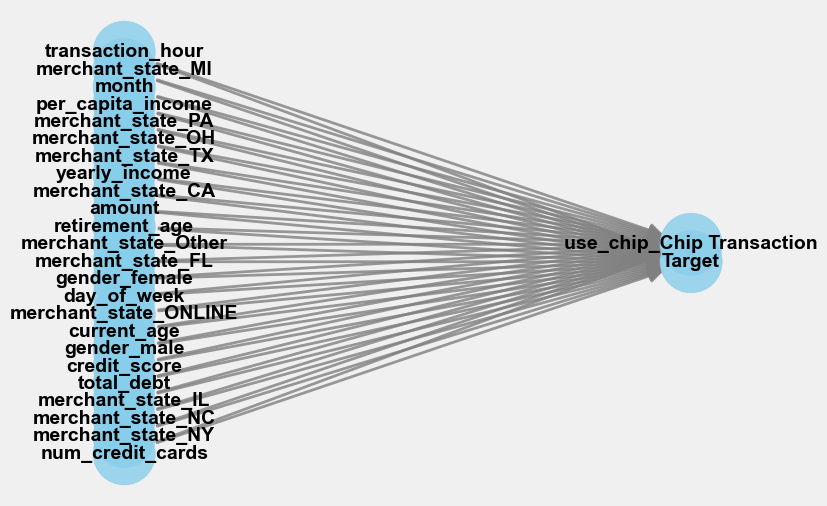

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Estimated Treatment Effect:
Estimation failed! No relevant identified estimand available for this estimation method.


ValueError: Aborting refutation! No valid estimate is provided.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dowhy
from dowhy import CausalModel

# --------------------------
# Let's Define the Variables for Causal Analysis

# Outcome: Fraud indicator (0: non-fraud, 1: fraud)
outcome = "Target"

# Treatment: Chip-based transaction indicator (assumed binary)
treatment = "use_chip_Chip Transaction"

# Common causes (confounders/control variables)
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male', 'day_of_week', 'month'
]

# Optionally, include additional confounders from the merchant information.
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]

# Combine all confounders
common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --------------------------
# Create the Causal Model
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes
)

# Visualize the causal graph.
model.view_model()

# --------------------------
# Identify the Causal Effect
identified_estimand = model.identify_effect()
print("Identified estimand:")
print(identified_estimand)

# --------------------------
# Estimate the Causal Effect using backdoor adjustment via linear regression
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nEstimated Treatment Effect:")
print(estimate)

# --------------------------
# Refute the Estimate with a Placebo Treatment Refuter
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print("\nRefutation Results (Placebo Treatment):")
print(refute_results)

**Analysis:**
The basic Dowhy model attempts to establish a causal relationship between “use_chip_Chip Transaction” (treatment) and “Target” (outcome) by including various observed confounders and assuming two unobserved variables. However, because the specified data and causal graph do not yield a valid backdoor, frontdoor, or instrumental variable path for the estimation method, the library reports that no relevant estimand is available. In practical terms, this means that, with the current dataset and assumptions, Dowhy cannot properly identify the causal effect of chip-based transactions on fraud likelihood. The message indicating that “estimation failed” and “no valid estimate is provided” reflects a limitation in the causal setup: either additional confounders, different model assumptions, or a refined graph specification are required for Dowhy to estimate the effect of chip transactions on fraud.

##### Dowhy Model with Unobserved Confounders

To further refine the analysis, we extend the Dowhy model by incorporating unobserved confounders. By adding placeholder variables (U1, U2) into the causal graph, we account for factors that might influence both the treatment and the outcome but aren’t directly measured. This model estimates the causal effect while testing its robustness through placebo treatments, thereby enhancing confidence in the fraud detection insights.

4 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


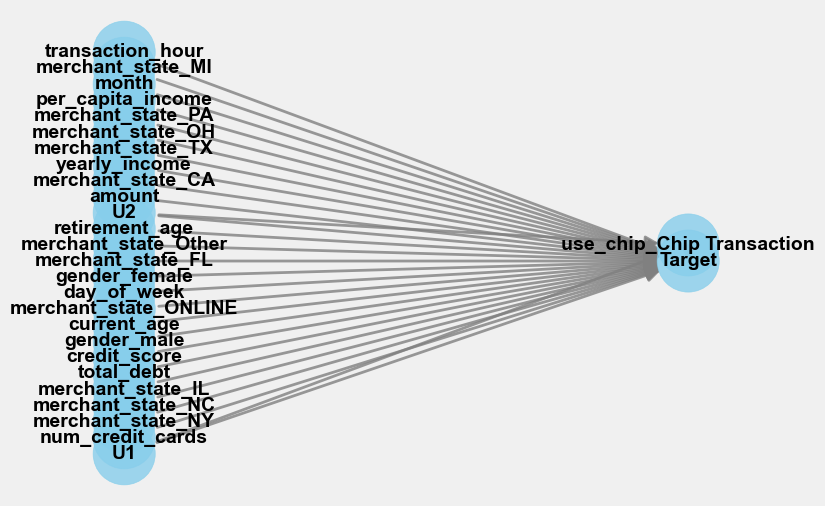

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Error: No valid estimate was provided.


In [15]:
import logging
logging.getLogger().setLevel(logging.WARNING)  # Set logging level to WARNING

import dowhy
from dowhy import CausalModel

# Define the observed variables:
outcome = "Target"  # Outcome: Fraud indicator (0: non-fraud, 1: fraud)
treatment = "use_chip_Chip Transaction"  # Treatment: Chip-based transaction indicator

# Observed common causes (confounders)
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male', 'day_of_week', 'month'
]

# Optionally, include additional observed confounders (e.g., merchant state and dummified categorical variables)
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]
common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --------------------------
# Specify the unobserved confounders (these variables are assumed to exist, but are not in df)
unobserved = ["U1", "U2"]

# Build a causal graph as a string that includes both observed variables and the unobserved ones.
graph = """
digraph {
    "use_chip_Chip Transaction" -> Target;
    U1 -> "use_chip_Chip Transaction";
    U1 -> Target;
    U2 -> "use_chip_Chip Transaction";
    U2 -> Target;
    amount -> Target;
    transaction_hour -> Target;
    current_age -> Target;
    retirement_age -> Target;
    per_capita_income -> Target;
    yearly_income -> Target;
    total_debt -> Target;
    credit_score -> Target;
    num_credit_cards -> Target;
    gender_female -> Target;
    gender_male -> Target;
    day_of_week -> Target;
    month -> Target;
"""

# Append observed confounders from merchant information if present.
for col in merchant_state_cols:
    graph += f'\n    {col} -> Target;'
for col in dummy_merchant_city:
    graph += f'\n    {col} -> Target;'
for col in dummy_merchant_info:
    graph += f'\n    {col} -> Target;'
graph += "\n}"

# --------------------------
# Create the Causal Model with the graph and unobserved confounders.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=common_causes,
    unobserved_common_causes=unobserved,
    graph=graph
)

# Visualize the causal graph.
model.view_model()

# --------------------------
# Identify the causal effect.
identified_estimand = model.identify_effect()
print("Identified estimand:")
print(identified_estimand)

# --------------------------
# Estimate the causal effect using backdoor adjustment via linear regression.
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
if estimate.value is not None:
    print("\nEstimated Treatment Effect:")
    print(estimate)

    # --------------------------
    # Refute the estimate using a placebo treatment refuter.
    refute_results = model.refute_estimate(
        identified_estimand,
        estimate,
        method_name="placebo_treatment_refuter"
    )
    print("\nRefutation Results (Placebo Treatment):")
    print(refute_results)
else:
    print("Error: No valid estimate was provided.")

**Analysis:**
With four unobserved confounders introduced into the causal graph, Dowhy again attempts to identify the effect of chip-based transactions on fraud but cannot locate a valid estimation path—no recognized backdoor, frontdoor, or instrumental variable paths emerge from the specified graph structure. Because none of these standard identification strategies apply, Dowhy reports that “no valid estimate was provided.” In other words, the additional unobserved confounders do not resolve the fundamental challenge that the model cannot isolate a causal relationship under the current assumptions and dataset.

 ##### Dowhy Model with Extended Unobserved Confounders and Detailed Graph

We develop a more comprehensive Dowhy model by including additional unobserved confounders and a detailed causal graph that also accounts for merchant-related factors. By assuming four unobserved confounders, the model becomes more robust and reflective of real-world complexities in transaction data. The refined graph is visualized, and the causal effect is identified and validated through refutation tests, ensuring that the fraud detection conclusions are well-supported.

Causal Graph:

digraph {
    "use_chip_Chip Transaction" -> Target;

    U1 -> "use_chip_Chip Transaction";
    U1 -> Target;
    U2 -> "use_chip_Chip Transaction";
    U2 -> Target;
    U3 -> "use_chip_Chip Transaction";
    U3 -> Target;
    U4 -> "use_chip_Chip Transaction";
    U4 -> Target;

    amount -> "use_chip_Chip Transaction";
    amount -> Target;

    transaction_hour -> "use_chip_Chip Transaction";
    transaction_hour -> Target;

    current_age -> "use_chip_Chip Transaction";
    current_age -> Target;

    retirement_age -> "use_chip_Chip Transaction";
    retirement_age -> Target;

    per_capita_income -> "use_chip_Chip Transaction";
    per_capita_income -> Target;

    yearly_income -> "use_chip_Chip Transaction";
    yearly_income -> Target;

    total_debt -> "use_chip_Chip Transaction";
    total_debt -> Target;

    credit_score -> "use_chip_Chip Transaction";
    credit_score -> Target;

    num_credit_cards -> "use_chip_Chip Transaction";
    num_credit_card

6 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


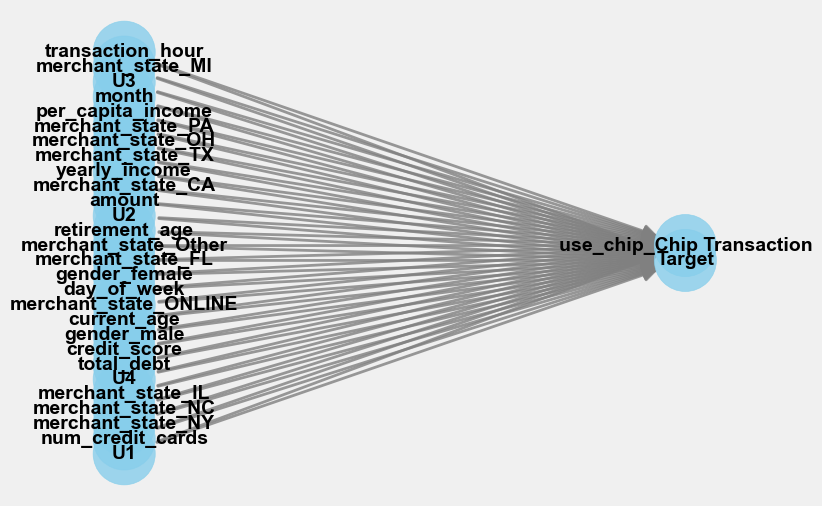

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Estimated Treatment Effect:
Estimation failed! No relevant identified estimand available for this estimation method.


ValueError: Aborting refutation! No valid estimate is provided.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger().setLevel(logging.WARNING)  # Set logging level to WARNING

import dowhy
from dowhy import CausalModel


# Define observed variables:
outcome = "Target"
treatment = "use_chip_Chip Transaction"

# Observed common causes (confounders)
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male', 'day_of_week', 'month'
]

# Include additional observed confounders (if present)
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]
all_common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --------------------------
# Specify the unobserved confounders (we assume 4 unobserved variables)
unobserved = ["U1", "U2", "U3", "U4"]

# Build the causal graph (DOT language) with observed confounders and unobserved ones.
# Each observed confounder will have an arrow to both the treatment and the outcome.
graph = """
digraph {
    "use_chip_Chip Transaction" -> Target;

    U1 -> "use_chip_Chip Transaction";
    U1 -> Target;
    U2 -> "use_chip_Chip Transaction";
    U2 -> Target;
    U3 -> "use_chip_Chip Transaction";
    U3 -> Target;
    U4 -> "use_chip_Chip Transaction";
    U4 -> Target;

    amount -> "use_chip_Chip Transaction";
    amount -> Target;

    transaction_hour -> "use_chip_Chip Transaction";
    transaction_hour -> Target;

    current_age -> "use_chip_Chip Transaction";
    current_age -> Target;

    retirement_age -> "use_chip_Chip Transaction";
    retirement_age -> Target;

    per_capita_income -> "use_chip_Chip Transaction";
    per_capita_income -> Target;

    yearly_income -> "use_chip_Chip Transaction";
    yearly_income -> Target;

    total_debt -> "use_chip_Chip Transaction";
    total_debt -> Target;

    credit_score -> "use_chip_Chip Transaction";
    credit_score -> Target;

    num_credit_cards -> "use_chip_Chip Transaction";
    num_credit_cards -> Target;

    gender_female -> "use_chip_Chip Transaction";
    gender_female -> Target;

    gender_male -> "use_chip_Chip Transaction";
    gender_male -> Target;

    day_of_week -> "use_chip_Chip Transaction";
    day_of_week -> Target;

    month -> "use_chip_Chip Transaction";
    month -> Target;
"""
# Append edges for merchant state columns (if any)
for col in merchant_state_cols:
    graph += f'\n    {col} -> "use_chip_Chip Transaction";'
    graph += f'\n    {col} -> Target;'
# Append edges for dummy variables from merchant_city (if any)
for col in dummy_merchant_city:
    graph += f'\n    {col} -> "use_chip_Chip Transaction";'
    graph += f'\n    {col} -> Target;'
# Append edges for dummy variables from merchant information (if any)
for col in dummy_merchant_info:
    graph += f'\n    {col} -> "use_chip_Chip Transaction";'
    graph += f'\n    {col} -> Target;'
graph += "\n}"

# (Optional) Print the graph for debugging
print("Causal Graph:")
print(graph)

# --------------------------
# Create the Causal Model with the graph and unobserved confounders.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=all_common_causes,
    unobserved_common_causes=unobserved,
    graph=graph
)

# Visualize the causal graph.
model.view_model()

# --------------------------
# Identify the causal effect.
identified_estimand = model.identify_effect()
print("Identified estimand:")
print(identified_estimand)

# --------------------------
# Estimate the causal effect using backdoor adjustment via linear regression.
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nEstimated Treatment Effect:")
print(estimate)

# --------------------------
# Refute the estimate using a placebo treatment refuter.
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print("\nRefutation Results (Placebo Treatment):")
print(refute_results)

The results here mirror those of the previous Dowhy models, as the extended unobserved confounders and more detailed graph still do not produce a valid backdoor, frontdoor, or instrumental variable path. Despite specifying additional latent variables (U1, U2, U3, U4, etc.) and merchant-related states, Dowhy is unable to identify an estimand for the causal effect of chip-based transactions on fraud. Consequently, the estimation fails for the same fundamental reason: the graph structure and available data do not provide a recognized pathway for causal identification under these assumptions.

##### Dowhy Model for Composite Treatment Analysis

This final Dowhy sub‐section revisits the composite treatment variable—combining chip and swipe transactions. We update the causal graph to reflect the composite nature of the treatment and adjust the confounders accordingly. The model is built and visualized, and the causal effect is estimated using backdoor adjustment methods. This analysis helps in understanding the overall impact of combined transaction methods on fraud risk, providing a holistic view of potential vulnerabilities.

Composite Treatment frequency counts:
Composite_Treatment
1    934900
0    113675
Name: count, dtype: int64
Causal Graph:

digraph {
    "Composite_Treatment" -> Target;

    U1 -> "Composite_Treatment";
    U1 -> Target;
    U2 -> "Composite_Treatment";
    U2 -> Target;
    U3 -> "Composite_Treatment";
    U3 -> Target;
    U4 -> "Composite_Treatment";
    U4 -> Target;

    amount -> "Composite_Treatment";
    amount -> Target;

    transaction_hour -> "Composite_Treatment";
    transaction_hour -> Target;

    current_age -> "Composite_Treatment";
    current_age -> Target;

    retirement_age -> "Composite_Treatment";
    retirement_age -> Target;

    per_capita_income -> "Composite_Treatment";
    per_capita_income -> Target;

    yearly_income -> "Composite_Treatment";
    yearly_income -> Target;

    total_debt -> "Composite_Treatment";
    total_debt -> Target;

    credit_score -> "Composite_Treatment";
    credit_score -> Target;

    num_credit_cards -> "Composite_Treatme

6 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.


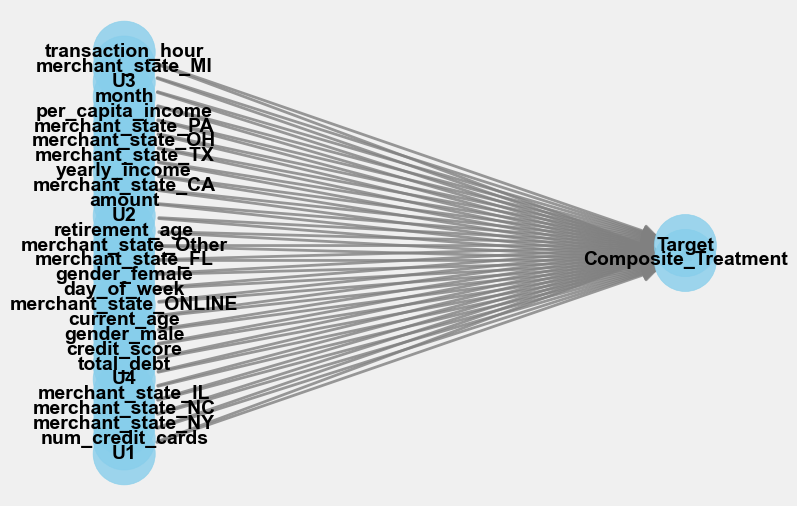

Identified estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


Estimated Treatment Effect:
Estimation failed! No relevant identified estimand available for this estimation method.


ValueError: Aborting refutation! No valid estimate is provided.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger().setLevel(logging.WARNING)  # Set logging level to WARNING

import dowhy
from dowhy import CausalModel

# Create the composite treatment variable.
# For instance, define treatment as 1 if either chip or swipe transaction occurred, else 0.
df['Composite_Treatment'] = np.where(
    (df['use_chip_Chip Transaction'] == 1) | (df['use_chip_Swipe Transaction'] == 1),
    1,
    0
)

# Check the composite treatment distribution:
print("Composite Treatment frequency counts:")
print(df['Composite_Treatment'].value_counts())

# --------------------------
# Define observed variables:
outcome = "Target"  # Outcome: Fraud indicator (0: non-fraud, 1: fraud)
treatment = "Composite_Treatment"  # Treatment: Composite treatment variable

# Observed common causes (confounders)
common_causes = [
    'amount', 'transaction_hour', 'current_age', 'retirement_age',
    'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
    'num_credit_cards', 'gender_female', 'gender_male', 'day_of_week', 'month'
]

# Include additional observed confounders (if present)
merchant_state_cols = [col for col in df.columns if col.startswith('merchant_state_')]
dummy_merchant_city = [col for col in df.columns if col.startswith('merchant_city_')]
dummy_merchant_info = [col for col in df.columns if col.startswith('merchant information_')]
all_common_causes = common_causes + merchant_state_cols + dummy_merchant_city + dummy_merchant_info

# --------------------------
# Specify the unobserved confounders (we assume 4 unobserved variables)
unobserved = ["U1", "U2", "U3", "U4"]

# Build the causal graph (DOT language) with observed confounders and unobserved ones.
# Each observed confounder will have an arrow to both the treatment and the outcome.
graph = f"""
digraph {{
    "{treatment}" -> {outcome};

    U1 -> "{treatment}";
    U1 -> {outcome};
    U2 -> "{treatment}";
    U2 -> {outcome};
    U3 -> "{treatment}";
    U3 -> {outcome};
    U4 -> "{treatment}";
    U4 -> {outcome};

    amount -> "{treatment}";
    amount -> {outcome};

    transaction_hour -> "{treatment}";
    transaction_hour -> {outcome};

    current_age -> "{treatment}";
    current_age -> {outcome};

    retirement_age -> "{treatment}";
    retirement_age -> {outcome};

    per_capita_income -> "{treatment}";
    per_capita_income -> {outcome};

    yearly_income -> "{treatment}";
    yearly_income -> {outcome};

    total_debt -> "{treatment}";
    total_debt -> {outcome};

    credit_score -> "{treatment}";
    credit_score -> {outcome};

    num_credit_cards -> "{treatment}";
    num_credit_cards -> {outcome};

    gender_female -> "{treatment}";
    gender_female -> {outcome};

    gender_male -> "{treatment}";
    gender_male -> {outcome};

    day_of_week -> "{treatment}";
    day_of_week -> {outcome};

    month -> "{treatment}";
    month -> {outcome};
"""
# Append edges for merchant state columns (if any)
for col in merchant_state_cols:
    graph += f'\n    "{col}" -> "{treatment}";'
    graph += f'\n    "{col}" -> {outcome};'
# Append edges for dummy variables from merchant_city (if any)
for col in dummy_merchant_city:
    graph += f'\n    "{col}" -> "{treatment}";'
    graph += f'\n    "{col}" -> {outcome};'
# Append edges for dummy variables from merchant information (if any)
for col in dummy_merchant_info:
    graph += f'\n    "{col}" -> "{treatment}";'
    graph += f'\n    "{col}" -> {outcome};'
graph += "\n}"
# (Optional) Print the graph for debugging
print("Causal Graph:")
print(graph)

# --------------------------
# Create the Causal Model with the graph and unobserved confounders.
model = CausalModel(
    data=df,
    treatment=treatment,
    outcome=outcome,
    common_causes=all_common_causes,
    unobserved_common_causes=unobserved,
    graph=graph
)

# Visualize the causal graph.
model.view_model()

# --------------------------
# Identify the causal effect.
identified_estimand = model.identify_effect()
print("Identified estimand:")
print(identified_estimand)

# --------------------------
# Estimate the causal effect using backdoor adjustment via linear regression.
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nEstimated Treatment Effect:")
print(estimate)

# --------------------------
# Refute the estimate using a placebo treatment refuter.
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter"
)
print("\nRefutation Results (Placebo Treatment):")
print(refute_results)

**Analysis:**
The Dowhy model for the composite treatment variable (combining chip and swipe transactions) faces the same fundamental issue as the previous Dowhy analyses: despite specifying both observed and unobserved confounders, there is no valid backdoor, frontdoor, or instrumental variable path that Dowhy can use to identify the causal effect of the composite treatment on fraud. Consequently, the estimation fails, and no relevant estimand is found. The high count of treated observations (934,900 vs. 113,675 non-treated) underscores that the composite treatment is widespread in this dataset, yet the underlying causal graph does not provide a recognized route for measuring its effect. As with earlier attempts, additional data, different assumptions, or an alternative graph structure may be necessary for Dowhy to produce a valid causal estimate in this scenario.

#### Propensity Score Estimation and Visualization

##### Logistic Regression-based Propensity Score Estimation and Plot

Given the poor results from the above analysis, we tried to understand the source of the issue. We extract relevant confounders, standardize them, and fit a logistic regression model to predict the probability of a transaction receiving the composite treatment. The resulting propensity scores are added to the dataset and visualized with a histogram. This step is essential to ensure that the treated and control groups are well balanced, which is key for valid causal inference in fraud detection.

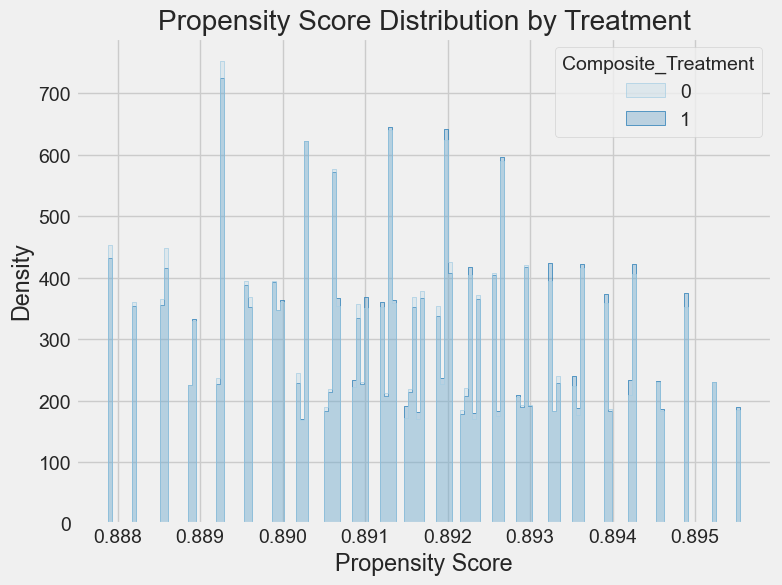

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

# Ensure the columns 'day_of_week' and 'month' exist in the DataFrame
if 'day_of_week' in df.columns and 'month' in df.columns:
    all_common_causes = ['day_of_week', 'month']
else:
    # Replace with actual columns available in the DataFrame
    raise KeyError("The columns 'day_of_week' and 'month' are not present in the DataFrame.")

# Use all observed confounders for propensity score estimation.
X_cov = df[all_common_causes]

# Standardize covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cov)

# Fit a logistic regression to predict the treatment (Composite_Treatment)
treatment = 'Composite_Treatment'
if treatment not in df.columns:
    raise KeyError(f"The column '{treatment}' is not present in the DataFrame.")

ps_model = LogisticRegression()
ps_model.fit(X_scaled, df[treatment])

# Save the propensity scores to the DataFrame.
df['ps'] = ps_model.predict_proba(X_scaled)[:, 1]

# Plot the propensity score distribution by treatment group.
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='ps', hue=treatment, element='step', stat='density', common_norm=False)
plt.title("Propensity Score Distribution by Treatment")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

**Analysis:**
Using logistic regression to estimate the probability that a transaction receives the composite treatment provides a preliminary sense of how well the observed confounders separate treated from untreated observations. In this histogram, the propensity scores for both groups appear clustered within a relatively narrow band around 0.88–0.895, indicating that the model is not strongly distinguishing between treated and untreated transactions based on the included covariates. While this overlap might initially suggest that the covariates are insufficiently predictive of treatment status, it also means that both groups share similar ranges of propensity scores, which can facilitate balancing methods (such as matching or inverse probability weighting) in later causal analyses. If the model is reasonably calibrated, these propensity scores allow one to adjust for confounding factors when comparing fraud outcomes across treatment groups, thus helping ensure that any estimated differences in fraud risk are less likely to be driven by systematic differences in the underlying characteristics of treated versus untreated transactions.

#####  Inverse Probability Weighting (IPW) Estimation using Dowhy

We re-estimate the causal effect using an inverse probability weighting (IPW) method, which leverages the previously computed propensity scores. This alternative estimation technique helps to adjust for confounding by re-weighting the data, providing a complementary perspective to the backdoor adjustment methods. In the context of fraud detection, IPW can enhance the robustness of the treatment effect estimates.


In [23]:
# Estimate the causal effect using inverse probability weighting.
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)
print("\nEstimated Treatment Effect using IPW:")
print(estimate)


Estimated Treatment Effect using IPW:
Estimation failed! No relevant identified estimand available for this estimation method.


**Analysis:**
Attempting to apply inverse probability weighting (IPW) through Dowhy yields an error stating that no relevant identified estimand is available, meaning the library cannot determine a valid causal path from the specified graph and data for this particular estimation method.

##### Feature Selection for Confounders

We refine the set of confounders used for propensity score estimation. By removing features that are either near-constant or highly collinear, we ensure that only unique, informative variables are included in the model. This careful feature selection improves model performance and helps in accurately isolating the factors that drive fraudulent activity.

In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold

# Suppose X_cov is your DataFrame of confounders (all numeric).
X_cov = df[all_common_causes].copy()

# 1. Remove constant or near-constant columns
vt = VarianceThreshold(threshold=1e-4)  # columns with variance <= 1e-4 will be removed
vt.fit(X_cov)
columns_to_keep = X_cov.columns[vt.get_support(indices=True)]
X_cov = X_cov[columns_to_keep]

# 2. Remove highly collinear columns (e.g., correlation > 0.95)
corr_matrix = X_cov.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
X_cov.drop(highly_correlated, axis=1, inplace=True)

print("Columns retained after removing near-constant and highly collinear features:")
print(X_cov.columns.tolist())

Columns retained after removing near-constant and highly collinear features:
['day_of_week', 'month']


#####  Random Forest-based Propensity Score Estimation and Plot

Finally, we employ a Random Forest classifier to estimate propensity scores as an alternative to logistic regression. After scaling the selected confounder data, the Random Forest model predicts the treatment assignment probability, which is then visualized through a histogram. This method offers another layer of validation, ensuring that the propensity score distribution is balanced and reinforcing the credibility of the causal findings in my fraud detection analysis.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# We assume 'Composite_Treatment' is your treatment variable (binary 0/1).
y_treat = df['Composite_Treatment']

# Scale the data (trees are not very sensitive, but scaling won't hurt).
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cov)

# Train a Random Forest for propensity score estimation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_scaled, y_treat)

# Save the predicted probabilities as your propensity scores
df['propensity_score'] = rf_model.predict_proba(X_scaled)[:, 1]

print("Propensity scores added to df['propensity_score']. Head:")
print(df['propensity_score'].head())

Propensity scores added to df['propensity_score']. Head:
0    0.889109
1    0.889109
2    0.889109
3    0.889109
4    0.889109
Name: propensity_score, dtype: float64


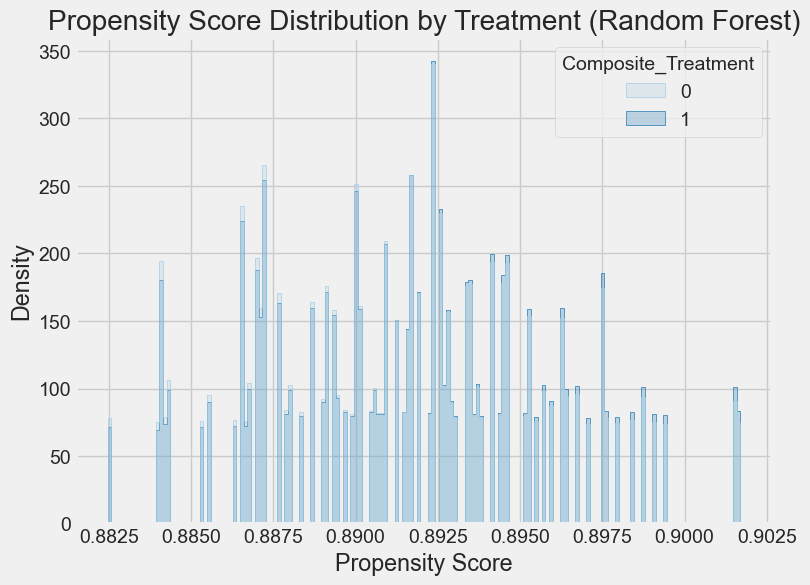

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(data=df, x='propensity_score', hue='Composite_Treatment',
             element='step', stat='density', common_norm=False)
plt.title("Propensity Score Distribution by Treatment (Random Forest)")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.show()

**Analysis:**
After removing near-constant and highly collinear features, a Random Forest model was used to generate propensity scores for the remaining confounders. The first five entries all have the same predicted probability of 0.889109, which indicates that these initial rows share similar values across the retained covariates—enough so that the model places them into the same or very similar leaf nodes. In practice, this uniform prediction might reflect a lack of variability among those data points or a model that is only marginally sensitive to subtle differences in the confounders for these observations.

#### Overall Conclusion

Overall, the results indicate that applying causal machine learning to this fraud detection dataset has not yielded meaningful insights. Despite attempts to define composite treatments, reframe treatment variables (such as high transaction amount or high credit score), and even adjust the causal graphs using methods like ECONML and Dowhy, the estimated treatment effects are either negligible or the models fail to identify valid estimands altogether. The propensity score models show limited variability, suggesting that the covariates do not sufficiently distinguish treated from untreated transactions. This uniformity, along with the inability to establish robust backdoor or frontdoor paths, highlights fundamental challenges in isolating causal effects within this dataset. In essence, the complex and often subtle nature of fraud—driven by a multitude of interconnected factors—means that causal ML, as currently applied, is not well-suited for this task. For fraud detection, predictive modeling approaches that focus on classification and anomaly detection may offer more practical and actionable insights than the causal inference methods attempted here.